In [1]:
#Importing packages
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [2]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [3]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:\\Users\\A\\Desktop\\Bioactive\\IL-1β")

In [4]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [5]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [6]:
#Reading the data
ML_data= pd.read_csv("./ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./data_psm.csv',index_col=0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(1134, 3964)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
OPTUM_LAB_ID,,,,,,,,,,,,,,,,,,,,,
53300413.0,704.02,6.518704,63.0926,107.4464,67.5519,122.5431,0.584191,0.994874,0.625481,1.134658,...,0.0,0.0,6.0,6.0,46.75,0.916667,10.625,0.208333,50.709541,12.001003
49795501.0,373.47,7.322941,31.3867,51.5196,32.6935,58.0300,0.615425,1.010188,0.641049,1.137843,...,0.0,0.0,5.0,6.0,23.50,0.870370,6.000,0.222222,21.400935,6.633250
9551212.0,487.74,6.869577,41.8673,70.7049,45.2221,80.6829,0.589680,0.995844,0.636931,1.136379,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,0.000000,0.000000,0.000000
53300217.0,515.47,8.182063,40.9322,63.5306,43.2048,70.5350,0.649717,1.008422,0.685790,1.119603,...,0.0,0.0,6.0,6.0,25.50,0.728571,4.000,0.114286,20.296826,3.602880
1254489.0,477.98,8.241034,38.5457,58.6579,40.0684,64.8437,0.664581,1.011343,0.690834,1.117995,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000,0.000000,0.000000,0.000000


In [7]:
Raw_data

,IsomericSMILES,Activity,Canonical_smiles
OPTUM_LAB_ID,,,
53300413.0,CCOC1=CC=C(C=C1)CCN2[C@H](CN(C(=O)C2=O)[C@@H](...,1,CCOc1ccc(CCN2C(=O)C(=O)N([C@@H](CC(C)C)CN3CCC[...
49795501.0,CC1=C(C=C(C=C1)F)C(=O)N2CCCCC2C3=CC(=NO3)C(=O)...,1,Cc1ccc(F)cc1C(=O)N1CCCCC1c1cc(C(=O)NC(C)C)no1
9551212.0,CC1CCN(CC1)CCCNC(=O)CCCNC(=O)CN2C=NC3=C(C2=O)C...,1,CC1CCN(CCCNC(=O)CCCNC(=O)Cn2cnc3sc4c(c3c2=O)CC...
53300217.0,CCOC(=O)[C@]12CCC=C1N(C(=O)[C@@H](C2)CC(=O)NCC...,1,CCOC(=O)[C@]12CCC=C1N(Cc1ccc(Cl)cc1Cl)C(=O)[C@...
1254489.0,C1CN(CCN1C2=CC=C(C=C2)NC(=O)C3=CC4=C(C=C3)OCCO...,1,O=C(Nc1ccc(N2CCN(C(=O)c3ccc(Cl)cc3)CC2)cc1)c1c...
...,...,...,...
53382587.0,COC(=O)C[C@H]1C=C[C@@H]([C@H](O1)CO)NC(=O)C2=C...,0,COC(=O)C[C@H]1C=C[C@H](NC(=O)c2ccccn2)[C@@H](C...
53301482.0,COC1=CC(=CC(=C1)C2=CC3=CC=CC=C3C(N2C4=CC=C(C=C...,0,COc1cc(OC)cc(C2=Cc3ccccc3C(CC(=O)c3ccco3)N2c2c...
53301383.0,C[C@H]1COC2=C(C=CC(=C2)N3CC[C@@H](C3)O)S(=O)(=...,0,C[C@H]1COc2cc(N3CC[C@H](O)C3)ccc2S(=O)(=O)N1


In [8]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(1134, 156)


,ESOL,MRcons,SHED_LL,QED,MaxaaCH,SpMin1_Bh(e),SpMin2_Bh(i),SpMax1_Bh(p),Eta_D_psiA,SpMax2_Bh(p),...,Eig08_EA(dm),CATS2D_03_DA,C-003,MATS3v,B10[C-O],F09[N-N],P_VSA_charge_1,C-006,GATS7e,F06[N-N]
OPTUM_LAB_ID,,,,,,,,,,,,,,,,,,,,,
53300413.0,0.374972,0.838102,0.947371,0.382994,0.891586,0.639835,0.779939,0.572376,0.414202,0.762623,...,0.549857,0.222222,0.333333,0.499714,1.0,0.4,0.204474,0.411765,0.486872,0.3
49795501.0,0.483465,0.305627,0.613480,0.927428,0.705690,0.655720,0.610128,0.556341,0.543594,0.658486,...,0.317460,0.111111,0.000000,0.588836,1.0,0.0,0.077861,0.058824,0.506351,0.1
9551212.0,0.543601,0.506036,0.843188,0.561356,0.000000,0.513069,0.654981,0.782782,0.384274,0.622166,...,0.407043,0.111111,0.166667,0.602432,1.0,0.2,0.098737,0.352941,0.402679,0.0
53300217.0,0.357407,0.503597,0.733585,0.562062,0.848486,0.637951,0.755576,0.647745,0.391578,0.752076,...,0.317460,0.000000,0.166667,0.498670,1.0,0.0,0.081053,0.176471,0.398732,0.0
1254489.0,0.391290,0.487277,0.825753,0.621663,0.873455,0.663602,0.765541,0.572797,0.422338,0.763210,...,0.317460,0.000000,0.000000,0.553357,1.0,0.0,0.116679,0.352941,0.304347,0.0


# DT

In [9]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=DecisionTreeClassifier(random_state=0)

In [10]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.620924,0.004830
Accuracy_train,0.999216,0.000039
F1 Score,0.621264,0.005117
Precision,0.621300,0.004976
Recall,0.623947,0.006672
Roc_auc,0.621550,0.004816


In [11]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.614386,0.004775
Accuracy_train,0.999216,0.000039
F1 Score,0.611899,0.005315
Precision,0.615798,0.004879
Recall,0.610793,0.007005
Roc_auc,0.615669,0.004776


In [12]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',3,5,1),
        'max_features' : trial.suggest_int("max_features",10,20,1),
        'min_samples_split':trial.suggest_int('min_samples_split',2,25,1)
    }
    model = DecisionTreeClassifier(**param,random_state=1)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-15 14:50:34,777] A new study created in memory with name: no-name-120d9a72-c30e-4828-8680-251fba0c5188
[I 2023-11-15 14:50:36,793] Trial 0 finished with value: 0.6171029343269678 and parameters: {'max_depth': 4, 'max_features': 17, 'min_samples_split': 16}. Best is trial 0 with value: 0.6171029343269678.
[I 2023-11-15 14:50:37,003] Trial 1 finished with value: 0.610997515913678 and parameters: {'max_depth': 4, 'max_features': 14, 'min_samples_split': 17}. Best is trial 0 with value: 0.6171029343269678.
[I 2023-11-15 14:50:37,220] Trial 2 finished with value: 0.6278442788386897 and parameters: {'max_depth': 4, 'max_features': 19, 'min_samples_split': 25}. Best is trial 2 with value: 0.6278442788386897.
[I 2023-11-15 14:50:37,344] Trial 3 finished with value: 0.6247647880763857 and parameters: {'max_depth': 4, 'max_features': 18, 'min_samples_split': 14}. Best is trial 2 with value: 0.6278442788386897.
[I 2023-11-15 14:50:37,565] Trial 4 finished with value: 0.632278372923459 

In [13]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf =DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)

The best parameters are : 
{'max_depth': 4, 'max_features': 10, 'min_samples_split': 8}


In [14]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.648232,0.004517
Accuracy_train,0.711150,0.001232
F1 Score,0.649553,0.005789
Precision,0.647017,0.004657
Recall,0.660310,0.009811
Roc_auc,0.672945,0.004545


In [15]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [16]:
data_dt=ML_data[columns]
data_dt.to_csv("./data_dt.csv",sep=',')
X_DT=np.array(data_dt)

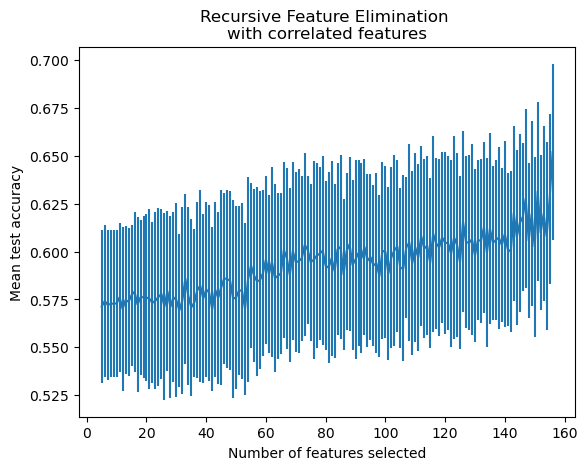

In [17]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [18]:
#Model4 （len(columns) descriptors）
Model4_clf=DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)
Model4_clf.fit(X_DT, y)
#Model4
Model4=Model_results(Model4_clf,X_DT,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.648232,0.004517
Accuracy_train,0.711150,0.001232
F1 Score,0.649553,0.005789
Precision,0.647017,0.004657
Recall,0.660310,0.009811
Roc_auc,0.672945,0.004545


In [19]:
Model4_clf=Model4_clf.fit(X_DT, y)
#Saving the final model
joblib.dump(Model4_clf, './DT.pkl')
DT= joblib.load(filename='./DT.pkl')

In [20]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./DT_model_data.csv",sep=',')
Model_data.columns = [['DecisionTree']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./DT_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/DT_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         DecisionTree                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.620924  0.004830  0.614386  0.004775  0.648232  0.004517   
Accuracy_train     0.999216  0.000039  0.999216  0.000039  0.711150  0.001232   
F1 Score           0.621264  0.005117  0.611899  0.005315  0.649553  0.005789   
Precision          0.621300  0.004976  0.615798  0.004879  0.647017  0.004657   
Recall             0.623947  0.006672  0.610793  0.007005  0.660310  0.009811   
Roc_auc            0.621550  0.004816  0.615669  0.004776  0.672945  0.004545   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.648232  0.004517  
Accuracy_train  0.711150  0.001232  
F1 Score        0.649553  0.005789  
Precision       0.647017  0.004657  
Recall          0.660310  0.009811  
Roc_auc         0.672945  0.004545

# LR

In [21]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=LogisticRegression(solver='liblinear',random_state=0)

In [22]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.682810,0.003948
Accuracy_train,0.837517,0.002013
F1 Score,0.683125,0.004246
Precision,0.682787,0.004231
Recall,0.685855,0.005881
Roc_auc,0.741222,0.004319


In [23]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.687576,0.004004
Accuracy_train,0.742779,0.000686
F1 Score,0.693285,0.004159
Precision,0.681531,0.004274
Recall,0.707892,0.005773
Roc_auc,0.749588,0.004313


In [24]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-3,  1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio",0.1,1,log=False) 
    #penalty = trial.suggest_categorical("penalty",['l1','l2'])
    max_iter = trial.suggest_int("max_iter", 100,2000)
    model =LogisticRegression(C=logreg_c,
                              max_iter=max_iter,
                              l1_ratio=l1_ratio,
                              solver='liblinear',random_state=1)
    
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-15 15:16:37,295] A new study created in memory with name: no-name-18266251-c7ca-48bf-a9ef-5ac50e735328
[I 2023-11-15 15:16:39,128] Trial 0 finished with value: 0.6911822698338769 and parameters: {'logreg_c': 0.3177840006884068, 'l1_ratio': 0.7482920440979423, 'max_iter': 100}. Best is trial 0 with value: 0.6911822698338769.
[I 2023-11-15 15:16:39,362] Trial 1 finished with value: 0.6964663872069555 and parameters: {'logreg_c': 0.0651621545821569, 'l1_ratio': 0.23208030173540176, 'max_iter': 275}. Best is trial 1 with value: 0.6964663872069555.
[I 2023-11-15 15:16:39,593] Trial 2 finished with value: 0.6879987579568391 and parameters: {'logreg_c': 0.013108749615263334, 'l1_ratio': 0.411004654338743, 'max_iter': 854}. Best is trial 1 with value: 0.6964663872069555.
[I 2023-11-15 15:16:39,905] Trial 3 finished with value: 0.689346374786524 and parameters: {'logreg_c': 1.7096232052870346, 'l1_ratio': 0.4772750629629653, 'max_iter': 1402}. Best is trial 1 with value: 0.6964663872

In [25]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=LogisticRegression(C=study.best_params['logreg_c'],
                              max_iter=study.best_params['max_iter'],
                              l1_ratio=study.best_params['l1_ratio'],
                              solver='liblinear',
                              random_state=1)

The best parameters are : 
{'logreg_c': 0.13413211350345164, 'l1_ratio': 0.48056211665964066, 'max_iter': 1267}


In [26]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.698142,0.003971
Accuracy_train,0.722173,0.000554
F1 Score,0.703449,0.004119
Precision,0.691641,0.004054
Recall,0.717769,0.005657
Roc_auc,0.756598,0.004256


In [27]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [28]:
data_lr=ML_data[columns]
data_lr.to_csv("./data_lr.csv",sep=',')
X_LR=np.array(data_lr)

In [29]:
data_lr

,ESOL,MRcons,SHED_LL,QED,MaxaaCH,SpMax1_Bh(p),Eta_D_psiA,O%,SpMaxA_EA(dm),VE1_H2,...,B09[O-O],SM1_Dz(Z),B02[N-O],H-051,C-033,Eig08_EA(dm),B10[C-O],F09[N-N],GATS7e,F06[N-N]
OPTUM_LAB_ID,,,,,,,,,,,,,,,,,,,,,
53300413.0,0.374972,0.838102,0.947371,0.382994,0.891586,0.572376,0.414202,0.235837,0.095648,0.722118,...,1.0,0.572828,1.0,0.000000,0.000000,0.549857,1.0,0.4,0.486872,0.3
49795501.0,0.483465,0.305627,0.613480,0.927428,0.705690,0.556341,0.543594,0.254169,0.185957,0.422647,...,0.0,0.381605,1.0,0.000000,0.000000,0.317460,1.0,0.0,0.506351,0.1
9551212.0,0.543601,0.506036,0.843188,0.561356,0.000000,0.782782,0.384274,0.161219,0.232326,0.289873,...,0.0,0.542065,1.0,0.444444,0.000000,0.407043,1.0,0.2,0.402679,0.0
53300217.0,0.357407,0.503597,0.733585,0.562062,0.848486,0.647745,0.391578,0.280357,0.287688,0.407065,...,0.0,0.656363,1.0,0.333333,0.000000,0.317460,1.0,0.0,0.398732,0.0
1254489.0,0.391290,0.487277,0.825753,0.621663,0.873455,0.572797,0.422338,0.311061,0.138438,0.890732,...,0.0,0.538630,1.0,0.000000,0.000000,0.317460,1.0,0.0,0.304347,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53382587.0,0.787807,0.192602,0.433151,0.591196,0.756405,0.373930,0.662634,0.625389,0.465603,0.399997,...,1.0,0.388922,1.0,0.222222,0.000000,0.317460,1.0,0.0,0.361507,0.0
53301482.0,0.257400,0.646353,0.497718,0.187605,0.914030,0.759756,0.380124,0.319234,0.119157,0.663843,...,1.0,0.431428,1.0,0.222222,0.333333,0.317460,1.0,0.0,0.438681,0.0
53301383.0,0.708092,0.179307,0.325971,0.851585,0.775251,0.842869,0.575329,0.514675,0.171369,0.251822,...,1.0,0.495888,1.0,0.000000,0.000000,0.317460,1.0,0.0,0.349459,0.1


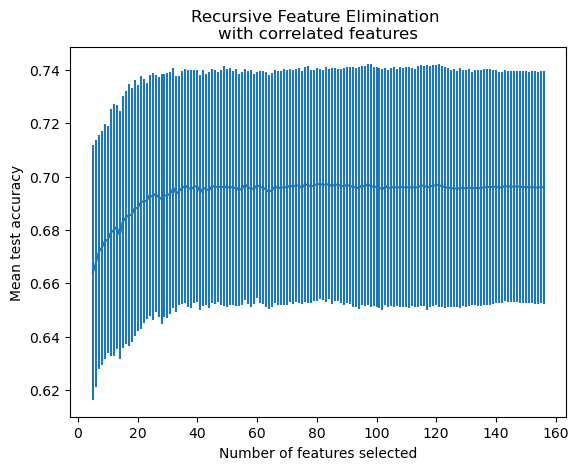

In [30]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [31]:
#Model4 （len(columns) descriptors）
Model4_clf=LogisticRegression(C=study.best_params['logreg_c'],max_iter=study.best_params['max_iter'],solver='liblinear',random_state=0)
#Model4
Model4=Model_results(Model4_clf,X_LR,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.706701,0.004072
Accuracy_train,0.721488,0.000566
F1 Score,0.710443,0.004218
Precision,0.701866,0.004244
Recall,0.721125,0.005536
Roc_auc,0.769640,0.004154


In [32]:
Model4_clf=Model4_clf.fit(X_LR, y)
#Saving the final model
joblib.dump(Model4_clf, './LogReg.pkl')
LogReg= joblib.load(filename='./LogReg.pkl')

In [33]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./LR_model_data.csv",sep=',')
Model_data.columns = [['LogisticRegression']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./LR_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         LogisticRegression                                          \
Model                     Model 1             Model 2             Model 3   
Values                       Mean        Se      Mean        Se      Mean   
Accuracy_test            0.682810  0.003948  0.687576  0.004004  0.698142   
Accuracy_train           0.837517  0.002013  0.742779  0.000686  0.722173   
F1 Score                 0.683125  0.004246  0.693285  0.004159  0.703449   
Precision                0.682787  0.004231  0.681531  0.004274  0.691641   
Recall                   0.685855  0.005881  0.707892  0.005773  0.717769   
Roc_auc                  0.741222  0.004319  0.749588  0.004313  0.756598   

Method                                        
Model                      Model 4            
Values                Se      Mean        Se  
Accuracy_test   0.003971  0.706701  0.004072  
Accuracy_train  0.000554  0.721488  0.000566  
F1 Score        0.004119  0.710443  0.004218  
Precision       0.004054  0.701866  0.004244  
Recall          0.005657  0.721125  0.005536  
Roc_auc         0.004256  0.769640  0.004154

# RF

In [34]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=RandomForestClassifier(random_state=0)

In [35]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.688701,0.004310
Accuracy_train,0.999216,0.000039
F1 Score,0.683981,0.004873
Precision,0.694657,0.004698
Recall,0.677159,0.006884
Roc_auc,0.755781,0.004639


In [36]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.704493,0.004364
Accuracy_train,0.999216,0.000039
F1 Score,0.697625,0.004781
Precision,0.714258,0.004743
Recall,0.684411,0.006454
Roc_auc,0.774863,0.004243


In [37]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",100,1000,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",5,20,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    #max_features = trial.suggest_categorical("max_features",["log2","sqrt","auto"]) #字符型
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease",0,5,log=False) #浮点型
    model = RandomForestClassifier(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_impurity_decrease = min_impurity_decrease
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)

[I 2023-11-15 15:23:18,999] A new study created in memory with name: no-name-8efe34f0-7bd8-43b0-9d00-7cd7bafd6581
[I 2023-11-15 15:23:29,472] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}. Best is trial 0 with value: 0.5.
[I 2023-11-15 15:23:36,748] Trial 1 finished with value: 0.4973451327433628 and parameters: {'n_estimators': 481, 'max_depth': 15, 'max_features': 16, 'min_impurity_decrease': 4.4588650039103985}. Best is trial 0 with value: 0.5.
[I 2023-11-15 15:23:51,439] Trial 2 finished with value: 0.4973451327433628 and parameters: {'n_estimators': 968, 'max_depth': 11, 'max_features': 25, 'min_impurity_decrease': 2.644474598764522}. Best is trial 0 with value: 0.5.
[I 2023-11-15 15:24:07,641] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 611, 'max_depth': 19, 'max_features': 6, 'min_impurity_decrease': 0.43564649850770354}. Best is trial 0 with value: 0.5

In [38]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 374, 'max_depth': 14, 'max_features': 9, 'min_impurity_decrease': 0.0005897666309665631}


In [39]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.706245,0.004143
Accuracy_train,0.998315,0.000081
F1 Score,0.700500,0.004696
Precision,0.713958,0.004367
Recall,0.690404,0.006655
Roc_auc,0.779948,0.004180


In [40]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [41]:
data_rf=ML_data[columns]
data_rf.to_csv("./data_rf.csv",sep=',')
X_RF=np.array(data_rf)

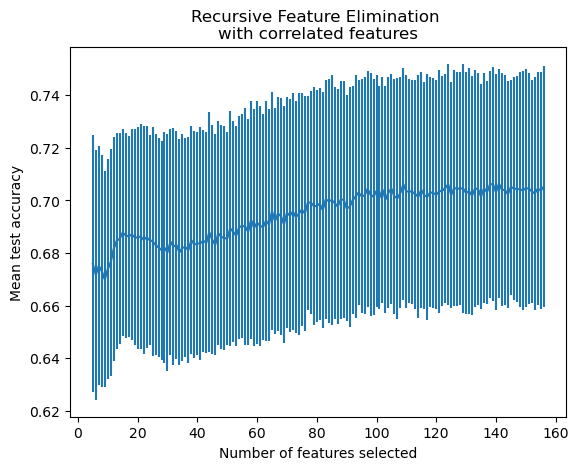

In [42]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [43]:
#Model4 （len(columns) descriptors）
Model4_clf=clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)
Model4_clf.fit(X_RF, y)
#Model4
Model4=Model_results(Model4_clf,X_RF,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.705639,0.004205
Accuracy_train,0.998383,0.000071
F1 Score,0.700087,0.004696
Precision,0.713326,0.004509
Recall,0.690072,0.006490
Roc_auc,0.780683,0.004150


In [44]:
Model4_clf=Model4_clf.fit(X_RF, y)
#Saving the final model
joblib.dump(Model4_clf, './RF.pkl')
RF= joblib.load(filename='./RF.pkl')

In [45]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./RF_model_data.csv",sep=',')
Model_data.columns = [['RandomForest']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./RF_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/RF_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         RandomForest                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.688701  0.004310  0.704493  0.004364  0.706245  0.004143   
Accuracy_train     0.999216  0.000039  0.999216  0.000039  0.998315  0.000081   
F1 Score           0.683981  0.004873  0.697625  0.004781  0.700500  0.004696   
Precision          0.694657  0.004698  0.714258  0.004743  0.713958  0.004367   
Recall             0.677159  0.006884  0.684411  0.006454  0.690404  0.006655   
Roc_auc            0.755781  0.004639  0.774863  0.004243  0.779948  0.004180   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.705639  0.004205  
Accuracy_train  0.998383  0.000071  
F1 Score        0.700087  0.004696  
Precision       0.713326  0.004509  
Recall          0.690072  0.006490  
Roc_auc         0.780683  0.004150

# xgboost

In [46]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=xgb.XGBClassifier(random_state=0)

In [47]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.692942,0.004543
Accuracy_train,0.999216,0.000039
F1 Score,0.689263,0.005008
Precision,0.697217,0.004690
Recall,0.683857,0.006559
Roc_auc,0.758257,0.004798


In [48]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.691188,0.004320
Accuracy_train,0.999216,0.000039
F1 Score,0.686038,0.004669
Precision,0.698037,0.004766
Recall,0.676814,0.006045
Roc_auc,0.756381,0.004090


In [49]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,1.0,step=0.1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, step=0.005),
        'n_estimators': trial.suggest_int("n_estimators",50,1000,1)
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param,random_state=1,n_jobs=8)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-15 16:18:28,570] A new study created in memory with name: no-name-6916c1dc-3eac-41ff-9ee1-0f404b20a20d
[I 2023-11-15 16:19:08,685] Trial 0 finished with value: 0.6993929514050613 and parameters: {'lambda': 0.15676677195506075, 'alpha': 0.7257005721594281, 'colsample_bytree': 0.7, 'subsample': 0.7000000000000001, 'learning_rate': 0.0801, 'n_estimators': 664}. Best is trial 0 with value: 0.6993929514050613.
[I 2023-11-15 16:19:36,191] Trial 1 finished with value: 0.693806086011489 and parameters: {'lambda': 0.0562793204741517, 'alpha': 3.6905577292137624, 'colsample_bytree': 1.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.1551, 'n_estimators': 552}. Best is trial 0 with value: 0.6993929514050613.
[I 2023-11-15 16:20:05,428] Trial 2 finished with value: 0.6906419810588416 and parameters: {'lambda': 0.18714500686240676, 'alpha': 5.039489598671215, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 841}. Best is trial 0 with value: 0.6993

In [50]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)

The best parameters are : 
{'lambda': 0.07830968129014693, 'alpha': 0.005612245797397568, 'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001, 'learning_rate': 0.015099999999999999, 'n_estimators': 630}


In [51]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.709786,0.004175
Accuracy_train,0.999216,0.000039
F1 Score,0.703045,0.004745
Precision,0.719043,0.004422
Recall,0.690216,0.006475
Roc_auc,0.777884,0.004200


In [52]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [53]:
data_xgb=ML_data[columns]
data_xgb.to_csv("./data_xgb.csv",sep=',')
X_XGB=np.array(data_xgb)

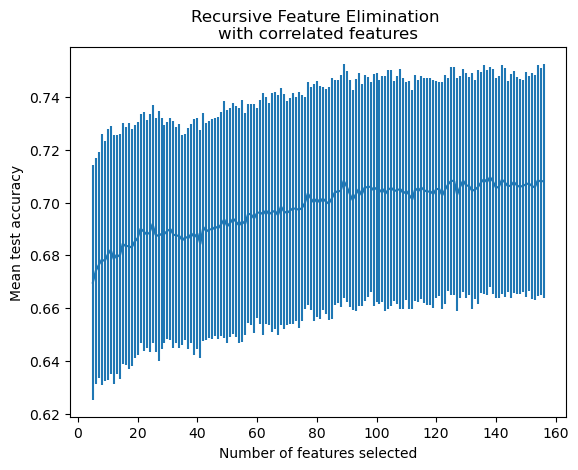

In [54]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [55]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.709355,0.004234
Accuracy_train,0.999206,0.000038
F1 Score,0.703623,0.004713
Precision,0.717745,0.004635
Recall,0.692873,0.006444
Roc_auc,0.778732,0.004134


In [56]:
Model4_clf=Model4_clf.fit(X_XGB, y)
#Saving the final model
joblib.dump(Model4_clf, './XGB.pkl')
XGB= joblib.load(filename='./XGB.pkl')

In [57]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./XGB_model_data.csv",sep=',')
Model_data.columns = [['XGBoost']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./XGB_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method           XGBoost                                                    \
Model            Model 1             Model 2             Model 3             
Values              Mean        Se      Mean        Se      Mean        Se   
Accuracy_test   0.692942  0.004543  0.691188  0.004320  0.709786  0.004175   
Accuracy_train  0.999216  0.000039  0.999216  0.000039  0.999216  0.000039   
F1 Score        0.689263  0.005008  0.686038  0.004669  0.703045  0.004745   
Precision       0.697217  0.004690  0.698037  0.004766  0.719043  0.004422   
Recall          0.683857  0.006559  0.676814  0.006045  0.690216  0.006475   
Roc_auc         0.758257  0.004798  0.756381  0.004090  0.777884  0.004200   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.709355  0.004234  
Accuracy_train  0.999206  0.000038  
F1 Score        0.703623  0.004713  
Precision       0.717745  0.004635  
Recall          0.692873  0.006444  
Roc_auc         0.778732  0.004134

In [7]:
XGB= joblib.load(filename='./XGB.pkl')
data_xgb=pd.read_csv("./data_xgb.csv",sep=',',header=0,index_col=0)

In [8]:
X_test_dataframe=pd.read_csv("./X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_xgb.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()


,ESOL,MRcons,SHED_LL,QED,MaxaaCH,SpMin1_Bh(e),SpMin2_Bh(i),SpMax1_Bh(p),Eta_D_psiA,SpMax2_Bh(p),...,nLevel9,P_VSA_MR_3,H-051,SdssC,C-026,Eig08_EA(dm),MATS3v,P_VSA_charge_1,C-006,GATS7e
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.765353,0.063323,0.052062,0.682481,0.810329,0.399283,0.317037,0.591444,0.600158,0.375234,...,0.0,0.038049,0.0,0.683491,0.0,0.31746,0.501358,0.110721,0.058824,0.426964
13463,0.760405,0.134994,0.000000,0.585916,0.633387,0.371314,0.334675,0.549744,0.737092,0.446033,...,0.0,0.333333,0.0,0.683491,0.0,0.31746,0.426960,0.326040,0.058824,0.409370
39148,0.816376,0.177441,0.000000,0.578836,0.665361,0.375550,0.421292,0.555597,0.708742,0.489064,...,0.0,0.333333,0.0,0.683491,0.0,0.31746,0.356150,0.333920,0.058824,0.312955
56328,0.749961,0.101754,0.000000,0.795037,0.627172,0.372144,0.326888,0.549490,0.792172,0.433420,...,0.0,0.185691,0.0,0.683491,0.0,0.31746,0.515426,0.218380,0.058824,0.415979
67358,0.899267,0.121615,0.000000,0.270696,0.518212,0.392235,0.344091,0.595924,0.877848,0.434682,...,0.0,0.480976,0.0,0.683491,0.0,0.31746,0.486539,0.501388,0.058824,0.441010


In [9]:
#Predicted results
Predicted_data=pd.DataFrame(XGB.predict_proba(X_test),columns=['Probability of nonactivity','Probability of activity'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of activity" , inplace=True, ascending=False)
Predicted_data.to_csv("./XGB_predict_data.csv",sep=',')